# Dataset Balancing

## Libraries and Configurations

In [1]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../../config.ini")

['../../config.ini']

Import **data libraries**

In [2]:
import pandas as pd

Import **other libraries**

In [3]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x778e01cfb990>>

Custom helper scripts

In [4]:
%cd ../../
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning/dissected

/home/bacci/COMPACT/notebooks
/home/bacci/COMPACT/notebooks/data_exploration_cleaning/dissected


## Import Data

In [5]:
# Combined dataframe raw
dissected_df_csv = config["DEFAULT"]["interim_path"] + "dissected/dissected_df_raw.csv"

In [6]:
dissected_df = pd.read_csv(dissected_df_csv)

/tmp/ipykernel_20939/4155439991.py:1: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  dissected_df = pd.read_csv(dissected_df_csv)


## Dataset Balancing

Visualize number of Probe Requests per device

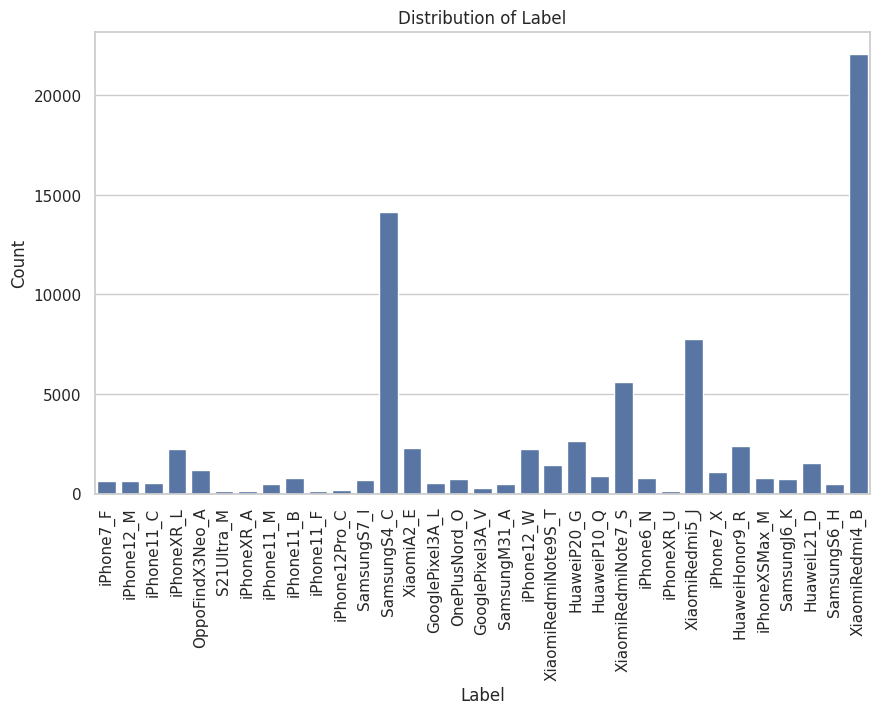

In [7]:
plotHelper.plot_label_distribution(dissected_df, "Label")

Average rows per label

In [8]:
print("Average number of rows per Label:", dissected_df.groupby("Label").size().mean())

Average number of rows per Label: 2324.3636363636365


**Undersampling devices which have too many Probe Request to the average number of rows per label**

In [9]:
# Undersampling devices which have too many Probe Request to the average number of rows per label
# This is done to avoid having an unbalanced dataset

# Get the average number of rows per label
average_rows_per_label = dissected_df.groupby("Label").size().mean()

# Get the labels which have more rows than the average
labels_to_undersample = (
    dissected_df.groupby("Label")
    .size()[dissected_df.groupby("Label").size() > average_rows_per_label]
    .index
)

# Get the labels which have less rows than the average
labels_to_keep = (
    dissected_df.groupby("Label")
    .size()[dissected_df.groupby("Label").size() <= average_rows_per_label]
    .index
)

# Get the rows which have a label which has more rows than the average
rows_to_undersample = dissected_df[dissected_df["Label"].isin(labels_to_undersample)]

# Get the rows which have a label which has less rows than the average
rows_to_keep = dissected_df[dissected_df["Label"].isin(labels_to_keep)]

# Undersample the rows which have a label which has more rows than the average
rows_to_undersample = (
    rows_to_undersample.groupby("Label")
    .apply(lambda x: x.sample(n=round(average_rows_per_label), random_state=42))
    .reset_index(drop=True)
)

# Combine the undersampled rows with the rows which have a label which has less rows than the average
dissected_df = pd.concat([rows_to_keep, rows_to_undersample])

/tmp/ipykernel_20939/38955987.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=round(average_rows_per_label), random_state=42))


Saving **balanced dataset**

In [10]:
dissected_df.to_csv(
    config["DEFAULT"]["interim_path"] + "dissected/balanced_dissected_df_raw.csv"
)

Filling NaN and saving

In [11]:
dissected_df.fillna(-1, inplace=True)

In [12]:
dissected_df.to_csv(
    config["DEFAULT"]["interim_path"] + "dissected/balanced_dissected_df.csv"
)